This notebook is to process and analyse data before model training.

The output file of this notebook `processed_data.csv` is also saved in `data/`

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

from src.utils import *
from src.text_mining_util import *
from src.ner import ParallelTextProcessor


In [3]:
# supprese warning
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# 0. Download news

# 1. Load and Preprocess Text

In [4]:
folder_path = "data/news/"

# read metadata
df = pd.read_csv(f"{folder_path}news_metadata.csv")
df.head()

webPublicationDate                                           webTitle  \
0  2019-01-13T08:00:03Z  The Great Boston Molasses Flood: why the stran...   
1  2019-01-10T01:41:36Z  Trump's threat to cut California wildfire reli...   
2  2019-02-27T21:07:58Z  Giant 'Glory Hole' sucks in rainwater as storm...   
3  2019-02-28T19:18:49Z  The flooded California wine country towns acce...   
4  2019-03-23T01:25:54Z  US disaster agency exposed private data of 2.3...   

                                              webUrl     type disaster_type  \
0  https://www.theguardian.com/us-news/2019/jan/1...  article         flood   
1  https://www.theguardian.com/us-news/2019/jan/0...  article      wildfire   
2  https://www.theguardian.com/us-news/2019/feb/2...  article         storm   
3  https://www.theguardian.com/us-news/2019/feb/2...  article         flood   
4  https://www.theguardian.com/us-news/2019/mar/2...  article      wildfire   

                         path  
0  data/news/2019_01_13_0.txt  
1  data/news/2019_01_10_1.txt  
2  data/news/2019_02_27_2.txt  
3  data/news/2019_02_28_3.txt  
4  data/news/2019_03_23_4.txt

In [5]:
# read article
for path in df.path.tolist():
    df['text'] = df.path.apply(read_txt)

# text preprocess
df['tokens'] = df['text'].apply(text_preprocessing)

df.head()

webPublicationDate                                           webTitle  \
0  2019-01-13T08:00:03Z  The Great Boston Molasses Flood: why the stran...   
1  2019-01-10T01:41:36Z  Trump's threat to cut California wildfire reli...   
2  2019-02-27T21:07:58Z  Giant 'Glory Hole' sucks in rainwater as storm...   
3  2019-02-28T19:18:49Z  The flooded California wine country towns acce...   
4  2019-03-23T01:25:54Z  US disaster agency exposed private data of 2.3...   

                                              webUrl     type disaster_type  \
0  https://www.theguardian.com/us-news/2019/jan/1...  article         flood   
1  https://www.theguardian.com/us-news/2019/jan/0...  article      wildfire   
2  https://www.theguardian.com/us-news/2019/feb/2...  article         storm   
3  https://www.theguardian.com/us-news/2019/feb/2...  article         flood   
4  https://www.theguardian.com/us-news/2019/mar/2...  article      wildfire   

                         path  \
0  data/news/2019_01_13_0.txt   
1  data/news/2019_01_10_1.txt   
2  data/news/2019_02_27_2.txt   
3  data/news/2019_02_28_3.txt   
4  data/news/2019_03_23_4.txt   

                                                text  \
0  For bystanders, the first clue something was w...   
1  Donald Trump’s latest threat to cut relief fun...   
2  Some say it looks like a toilet being flushed;...   
3  Floodwaters turned two northern California win...   
4  The US disaster relief agency unnecessarily re...   

                                              tokens  
0  [bystander, first, clue, something, wrong, sou...  
1  [donald, trump, latest, threat, cut, relief, f...  
2  [say, look, like, toilet, flush, generous, int...  
3  [floodwaters, turn, two, northern, california,...  
4  [u, disaster, relief, agency, unnecessarily, r...

# 2. Basic Text Analysis

### Topic Distribution

Number of disaster type: 11


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'flood'),
  Text(1, 0, 'wildfire'),
  Text(2, 0, 'storm'),
  Text(3, 0, 'tornado'),
  Text(4, 0, 'hurricane'),
  Text(5, 0, 'earthquake'),
  Text(6, 0, 'tsunami'),
  Text(7, 0, 'drought'),
  Text(8, 0, 'cyclone'),
  Text(9, 0, 'blizzard'),
  Text(10, 0, 'derecho')])

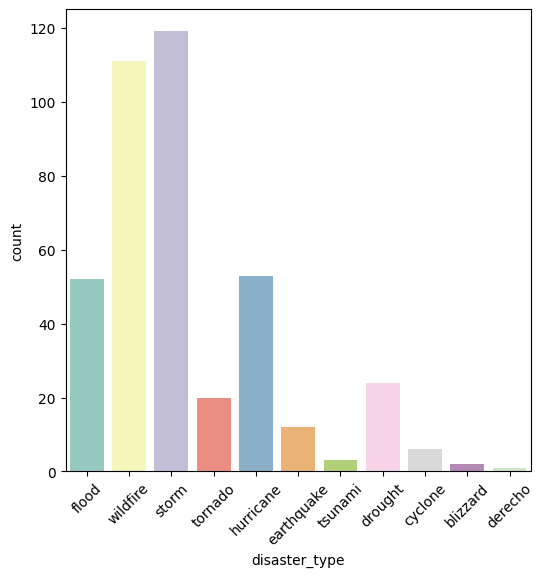

In [6]:
# plot distribution of disater
print(f"Number of disaster type: {df.disaster_type.nunique()}")
plt.figure(figsize=(6, 6))  # Set the figure size
sns.countplot(x='disaster_type', data=df, palette='Set3') 
plt.xticks(rotation=45)

### Word Cloud

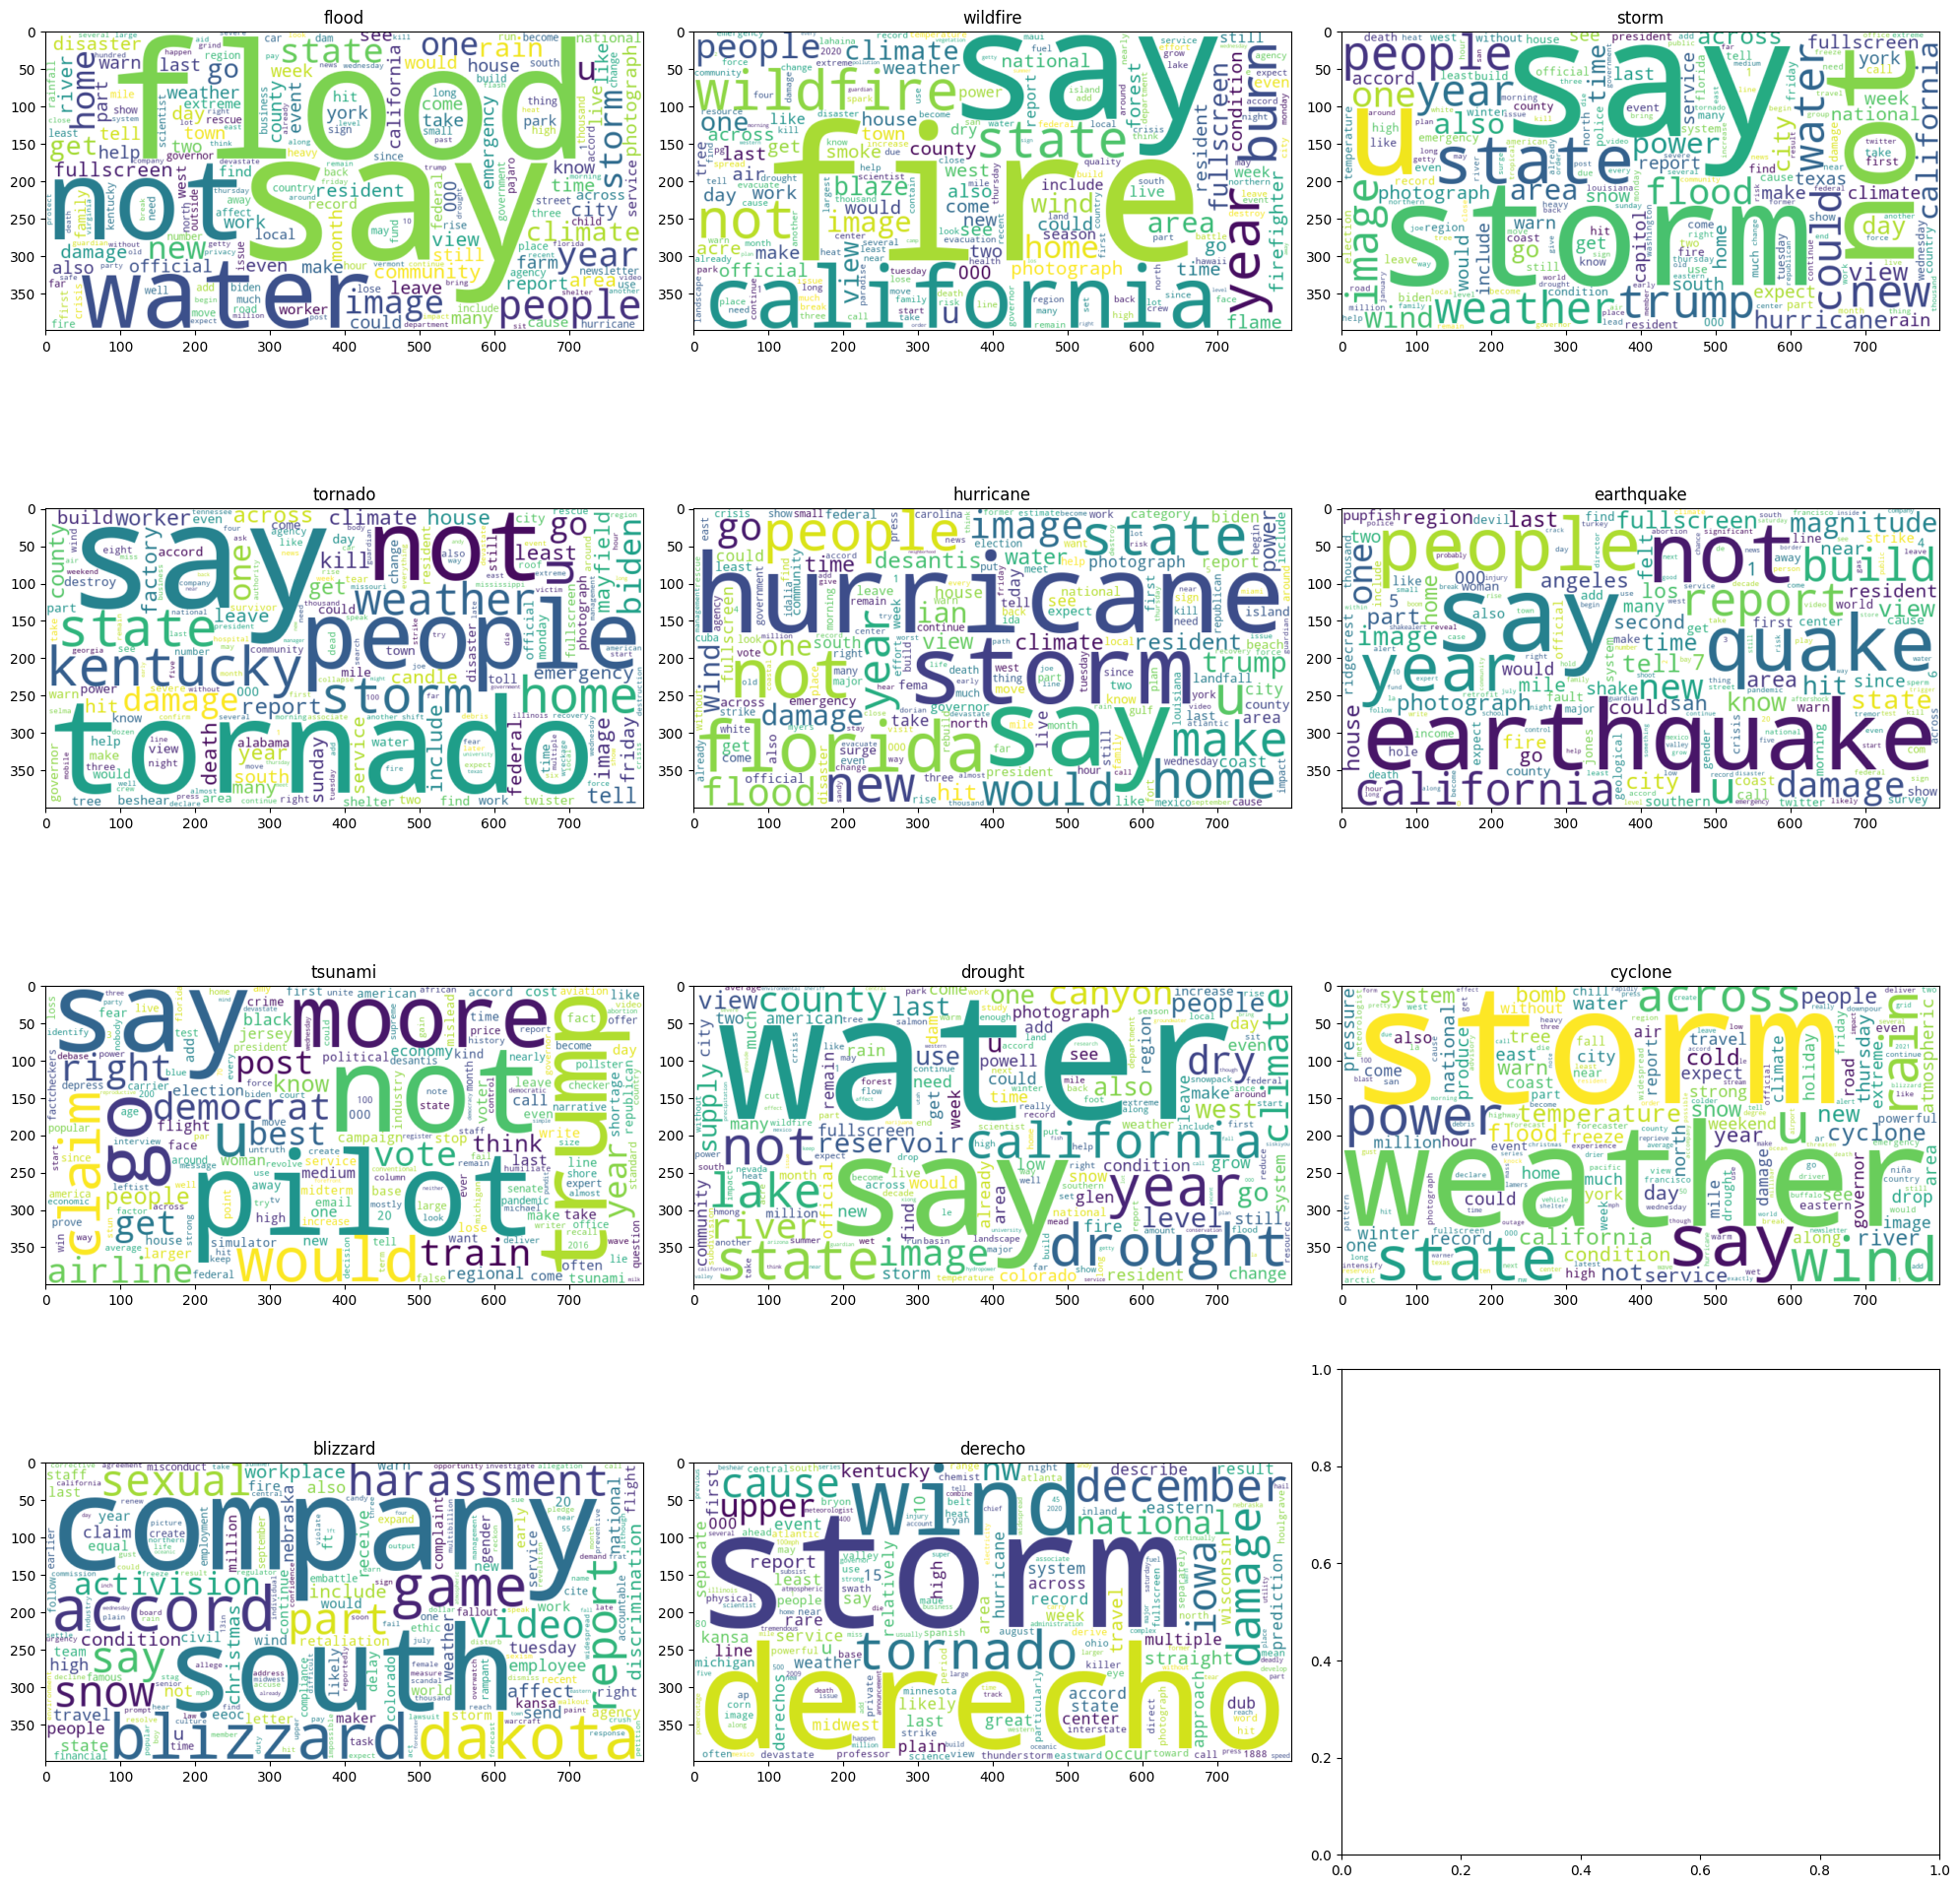

In [7]:
# Plot cloud graph for each type of diaster (1 gram)

fig, axs = plt.subplots(4, 3, figsize=(20, 20))

for i, type in enumerate(df.disaster_type.unique()):
   temp = df[df.disaster_type==type]
   text = " ".join(temp.tokens.apply(lambda x: " ".join(x)).tolist())
   plot_wordcloud(text, ax=axs[i//3, i%3])
   axs[i//3, i%3].set_title(type)

plt.tight_layout()

### Histogram of Basic Statistics

In [8]:
# Visualise basic statistics
num_chars, num_nonwhite_chars, num_number = basic_feature_extraction(df.text.tolist())
df["num_chars"] = num_chars
df["num_nonwhite_chars"] = num_nonwhite_chars
df["num_number"] = num_number

Text(0.5, 1.0, 'Histogram of charactor number')

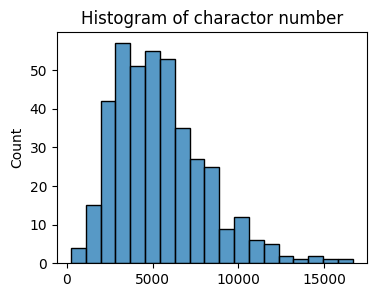

In [9]:
plt.figure(figsize=(4, 3))

sns.histplot(num_chars)
plt.title('Histogram of charactor number')

Text(0.5, 1.0, 'Histogram of nonwhite charactor number')

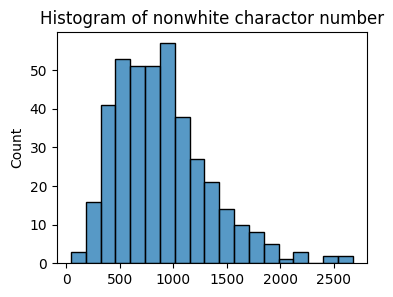

In [10]:
plt.figure(figsize=(4, 3))

sns.histplot(num_nonwhite_chars)
plt.title('Histogram of nonwhite charactor number')

Text(0.5, 1.0, 'Histogram of number')

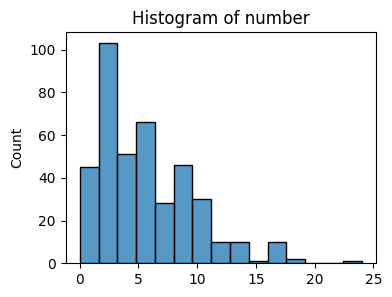

In [11]:
plt.figure(figsize=(4, 3))

sns.histplot(num_number)
plt.title('Histogram of number')

# 3. Important Terms (TF-IDF)

In [12]:
# tfidf feature
tfidf_matrix, disaster_dataset, feature_name = tfidf_feature(pd_dataset=df, max_features=20, ngram_range=(1, 5), text_corpus=df.text.tolist())

In [13]:
# top 100 tfidf terms (1 gram)
top_N_tfidf(create_tfidf_df(df.tokens, n_gram=1), 100)


['vest',
 'giuliani',
 'daskey',
 'goat',
 'census',
 'pakistan',
 'tanden',
 'pilot',
 'fauci',
 'zello',
 'morgan',
 'paradise',
 'centreville',
 'tubman',
 'saelee',
 'dow',
 'campbell',
 'gianforte',
 'clinton',
 'salmon',
 'pupfish',
 'derecho',
 'guerneville',
 'reef',
 'boom',
 'sequoia',
 'formula',
 'meadow',
 'fire',
 'taylor',
 'quake',
 'sharifu',
 'shoopman',
 'harris',
 'lake',
 'lahaina',
 'petrillo',
 'beaver',
 'molasses',
 'gender',
 'wed',
 'farm',
 'perryton',
 'desantis',
 'buffalo',
 'earthquake',
 'alaska',
 'misinformation',
 'trump',
 'haefner',
 'pajaro',
 'park',
 'montpelier',
 'elsa',
 'pg',
 'snow',
 'tarrio',
 'insurance',
 'waverly',
 'carlin',
 'water',
 'tchula',
 'drought',
 'mosquito',
 'glory',
 'australia',
 'lauder',
 'dakota',
 'osterholm',
 'loop',
 'canyon',
 'excess',
 'wisconsin',
 'shark',
 'edgemere',
 'hurricane',
 'babbitt',
 'havasupai',
 'undocumented',
 'henri',
 'florida',
 'hare',
 'ar',
 'subdivision',
 'folsom',
 'tornado',
 'niro'

In [14]:
# top 100 tfidf terms (2 gram)
top_N_tfidf(create_tfidf_df(df.tokens, n_gram=2), 100)

['devil hole',
 'petrillo haefner',
 'glen canyon',
 'exceptional event',
 'excess death',
 'lake powell',
 'mexico beach',
 'gender reveal',
 'glory hole',
 'baby formula',
 'de niro',
 'state farm',
 'west nile',
 'air quality',
 'little pakistan',
 'lake charles',
 'select committee',
 'ocasio cortez',
 'miami luken',
 'harris mile',
 'folsom lake',
 'watch duty',
 'nile virus',
 'hmong american',
 'south dakota',
 'january 2021',
 'dust bowl',
 'new orleans',
 'new mexico',
 'fullscreen photograph',
 'tell time',
 'harris say',
 'coral reef',
 'national park',
 'carbon monoxide',
 'robert taylor',
 'new hampshire',
 'injection well',
 'east palestine',
 'opioid pill',
 'sierra tahoe',
 'story hour',
 'storm surge',
 'new york',
 'rachel bujalski',
 'bujalski guardian',
 'event rule',
 'kimberly price',
 'heat record',
 'video game',
 'sexual harassment',
 'hell week',
 'harriet tubman',
 'photograph reveal',
 'satellite photograph',
 'ida one',
 'regional airline',
 'belt road',
 '

In [15]:
# top 100 tfidf terms (3 gram)
top_N_tfidf(create_tfidf_df(df.tokens, n_gram=3), 100)

['west nile virus',
 'exceptional event rule',
 'image fullscreen photograph',
 'rachel bujalski guardian',
 'august 27 2020',
 'petrillo haefner say',
 'lake tahoe wildlife',
 'satellite photograph reveal',
 'kill least four',
 'photograph reveal damage',
 'reveal damage cause',
 'coast storm kill',
 'million resident louisiana',
 'hurricane ida one',
 'gulf coast storm',
 'ever hit gulf',
 'leave million resident',
 'resident louisiana without',
 'ida one powerful',
 'least four people',
 'four people leave',
 'glen canyon dam',
 'gender reveal party',
 'devil hole pupfish',
 'louisiana without electricity',
 'storm ever hit',
 'cause hurricane ida',
 'people leave million',
 'osterholm tell nbc',
 'queen story hour',
 'drag queen story',
 'tahoe wildlife care',
 'mob storm capitol',
 'powerful storm ever',
 'hit gulf coast',
 'damage cause hurricane',
 'nielsen gammon say',
 'photograph rachel bujalski',
 'earthquake magnitude greater',
 'felt santa teresa',
 'false mislead claim',


# 4. Sentiment Analysis and Readability Analysis

In [16]:
# sentiment analysis
disaster_dataset = sentiment(pd_dataset=disaster_dataset)

Text(0.5, 1.0, 'Histogram of news polarity')

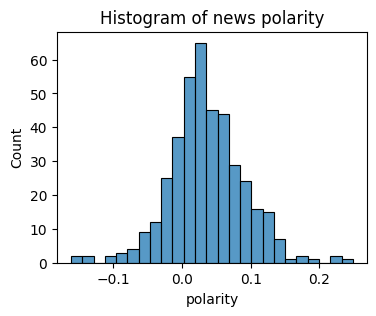

In [17]:
plt.figure(figsize=(4, 3))

sns.histplot(disaster_dataset.polarity)
plt.title('Histogram of news polarity')

Text(0.5, 1.0, 'Histogram of news subjectivity')

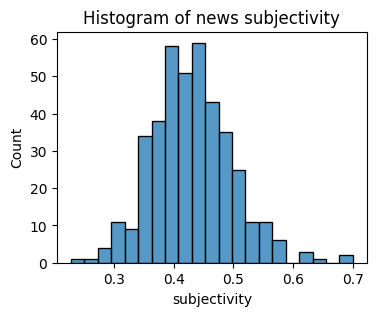

In [18]:
plt.figure(figsize=(4, 3))

sns.histplot(disaster_dataset.subjectivity)
plt.title('Histogram of news subjectivity')

In [19]:
# readability analysis
disaster_dataset = readability(pd_dataset=disaster_dataset)

# 5. Stock Information

In [23]:
# import stock data
stock_data = pd.read_csv("data/tel_return.csv", sep=',', lineterminator='\n', dtype={"date": str})
stock_data.head()

PERMNO      date  EXCHCD  SICCD                      COMNAM    PRC  \
0   65875  20100104       1   4813  VERIZON COMMUNICATIONS INC  33.28   
1   65875  20100105       1   4813  VERIZON COMMUNICATIONS INC  33.34   
2   65875  20100106       1   4813  VERIZON COMMUNICATIONS INC  31.92   
3   65875  20100107       1   4813  VERIZON COMMUNICATIONS INC  31.73   
4   65875  20100108       1   4813  VERIZON COMMUNICATIONS INC  31.75   

        VOL       RET    BID    ASK   SHROUT  NUMTRD  drop  lagged_VOL  \
0  15173000  0.004528  33.27  33.28  2840648     NaN     0         NaN   
1  22252100  0.001803  33.32  33.33  2840648     NaN     0  15173000.0   
2  35184200 -0.028344  31.91  31.92  2840648     NaN     1  22252100.0   
3  23925500 -0.005952  31.72  31.73  2840648     NaN     1  35184200.0   
4  19376800  0.000630  31.74  31.75  2840648     NaN     0  23925500.0   

               delt_vol\r  
0                      \r  
1   0.31813177183277086\r  
2    0.3675541862540572\r  
3   -0.4705732377588765\r  
4  -0.23474980388918706\r

In [41]:
df["date"] = df["pub_date"].str[0:4] + df["pub_date"].str[5:7] + df["pub_date"].str[8:10]

df = pd.merge(stock_data[["date", 'drop']], df, on="date")

<Axes: >

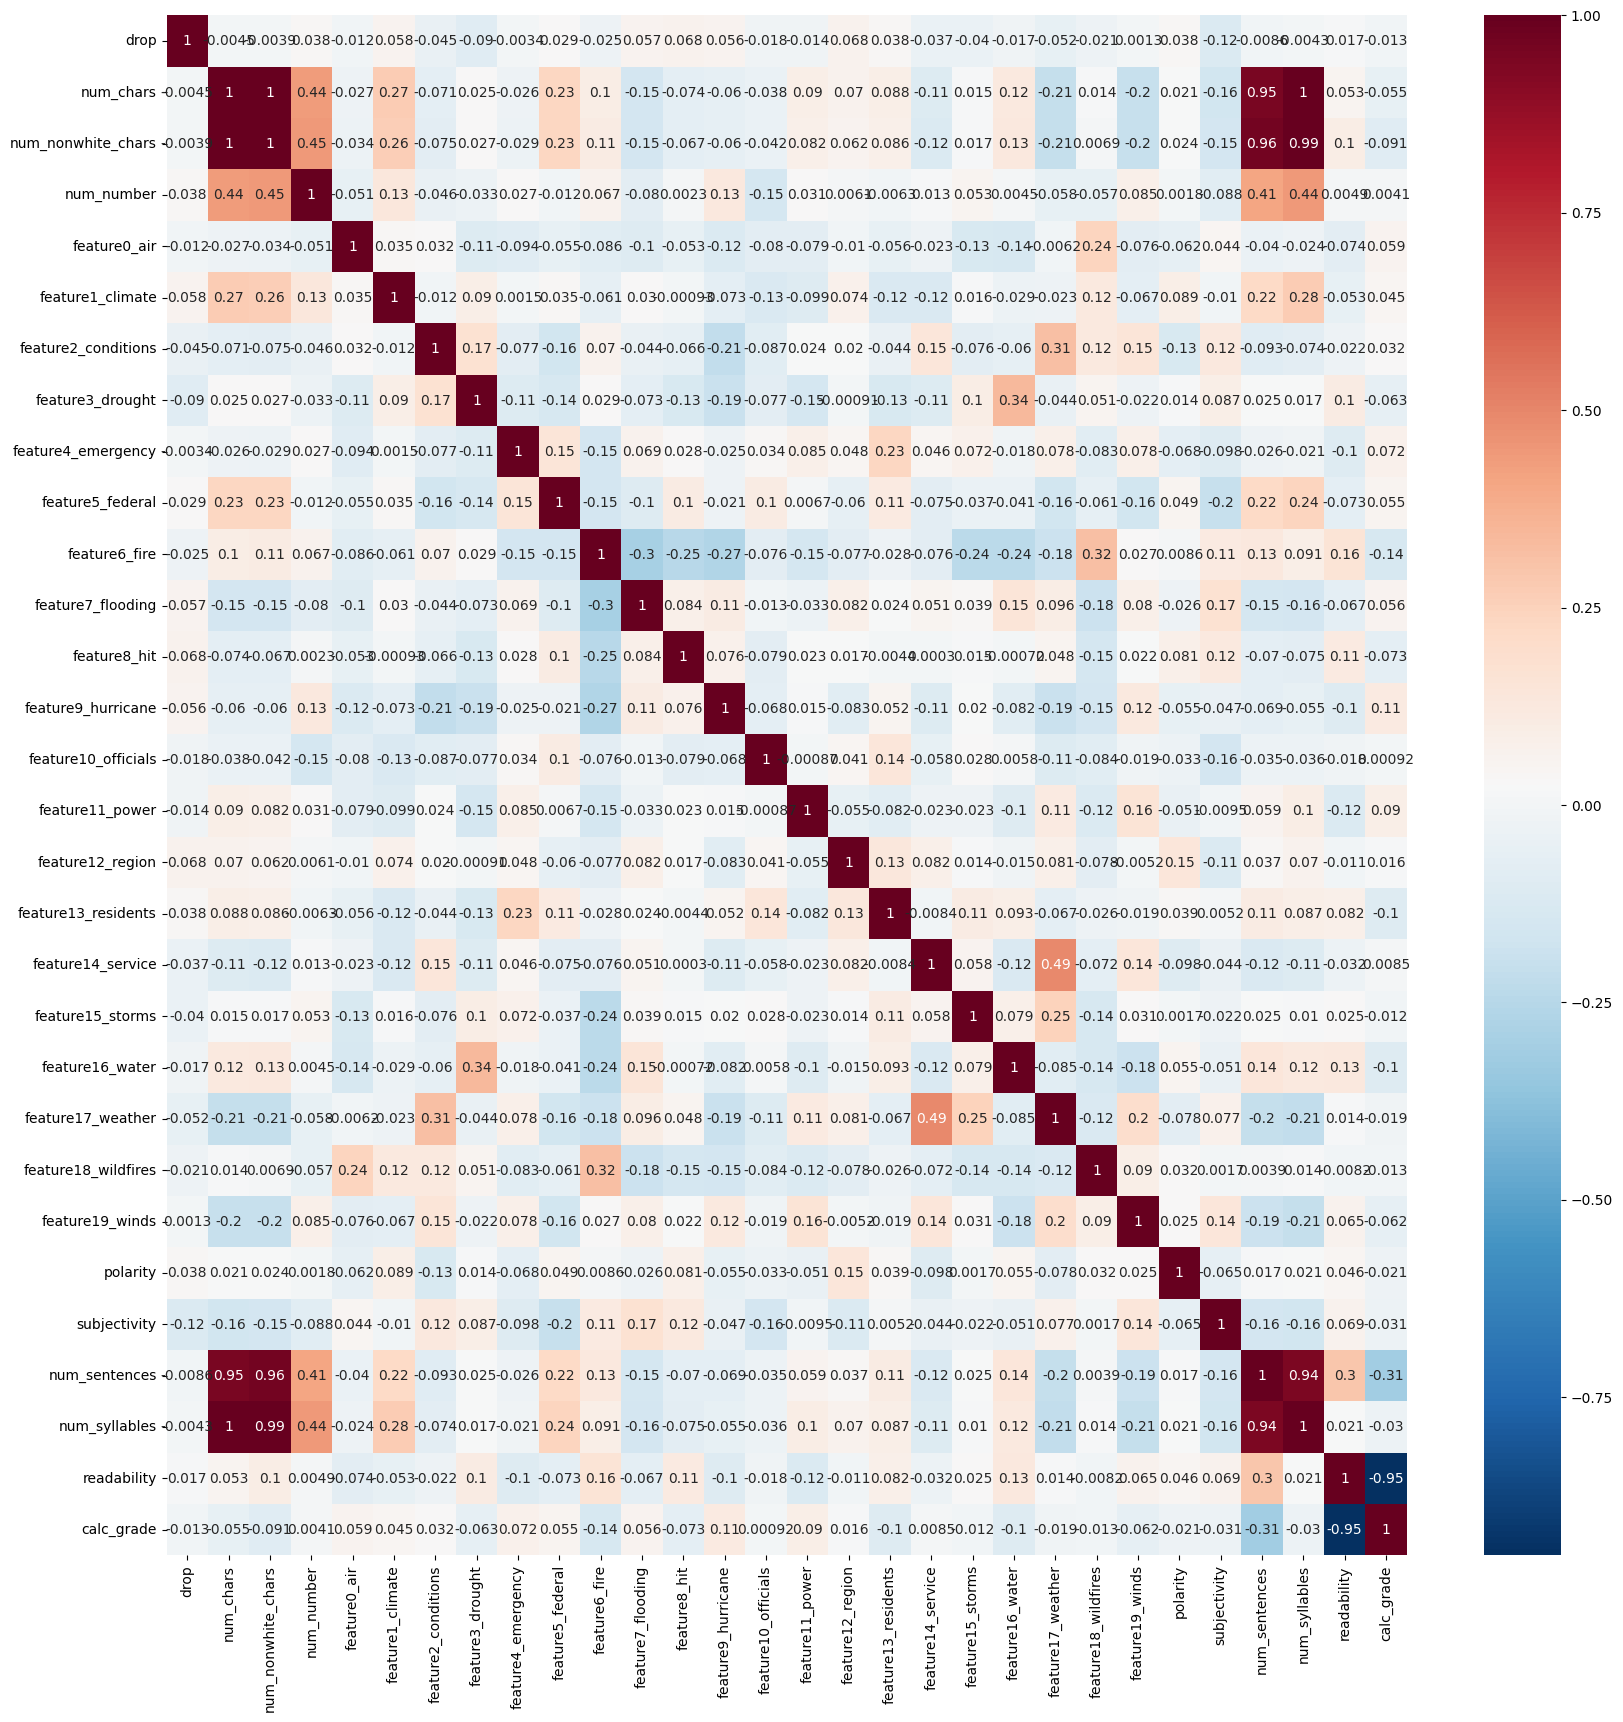

In [46]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap="RdBu_r")

# 6. Named Entity Recognition (NER)

### NER tag and geographic info


Due to the limits of API request to get geographic information, this data processing step is extremely slow. 

In [27]:
batch_size = 10
df = disaster_dataset.copy()
df = df.rename(columns={"webPublicationDate":"pub_date"})

text_processor = ParallelTextProcessor(chunk_size=500000)

In [ ]:
# Initialize new columns if they don't exist (based on expected keys)
expected_keys = ['state', 'region', 'area', 'GDP', 'population', 'longitude', 'latitude', 'error']
for key in expected_keys:
    if key not in df.columns:
        df[key] = None

# Iterate through the DataFrame with a progress bar
for start in range(0, len(df), batch_size):        
    end = start + batch_size
    batch = df[start:end]

    for index, row in tqdm(batch.iterrows(),  total=batch.shape[0], desc="Processing Rows"):
        year = int(row['pub_date'][:4])
        text = row['text']
        state_info_list = text_processor.process_text(text, year)
        
        # Append the information to the DataFrame
        if state_info_list and isinstance(state_info_list, list):
            state_info = state_info_list[0]
            for key in state_info:
                batch.at[index, key] = state_info[key]

    if start == 0:
        batch.to_csv('data/processed_data/processed_data.csv', mode='w', header=True, index=False)
    else:
        batch.to_csv('data/processed_data/processed_data.csv', mode='a', header=False, index=False)
    
    time.sleep(3)

Processing Rows:   0%|          | 0/10 [00:00<?, ?it/s]

Processing Rows: 100%|██████████| 10/10 [02:42<00:00, 16.29s/it]


In [35]:
ner_df = pd.read_csv("data/processed_data/processed_data.csv")
ner_df.head()

PERMNO      date  EXCHCD  SICCD                      COMNAM    PRC  \
0   65875  20190110       1   4813  VERIZON COMMUNICATIONS INC  57.60   
1   65875  20190227       1   4813  VERIZON COMMUNICATIONS INC  56.72   
2   65875  20190228       1   4813  VERIZON COMMUNICATIONS INC  56.92   
3   65875  20190305       1   4813  VERIZON COMMUNICATIONS INC  56.08   
4   65875  20190523       1   4813  VERIZON COMMUNICATIONS INC  58.87   

        VOL       RET    BID    ASK  ...  readability     read_grade  \
0  14259910  0.009641  57.57  57.58  ...       41.797  College Level   
1   8962776  0.001412  56.71  56.72  ...       57.821     11th Grade   
2  15742971  0.003526  56.91  56.92  ...       53.236     11th Grade   
3  15749545 -0.002845  56.07  56.08  ...       50.965     11th Grade   
4  11707083 -0.006414  58.89  58.90  ...       68.938      9th Grade   

   calc_grade       state  region    area        GDP  population   longitude  \
0      12.688  California    West  163695  3062158.9  39283497.0 -118.755997   
1      10.177  California    West  163695  3062158.9  39283497.0 -118.755997   
2      10.415  California    West  163695  3062158.9  39283497.0 -122.987129   
3      11.807     Alabama   South   52420   234526.4   4876250.0  -86.829534   
4       8.006     Florida   South   65758  1127988.6  20901636.0  -85.419395   

    latitude  
0  36.701463  
1  36.701463  
2  38.511661  
3  33.258882  
4  29.948483  

[5 rows x 60 columns]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'California'),
  Text(1, 0, 'Florida'),
  Text(2, 0, 'Texas'),
  Text(3, 0, 'New York'),
  Text(4, 0, 'Louisiana'),
  Text(5, 0, 'Washington'),
  Text(6, 0, 'Hawaii'),
  Text(7, 0, 'Kentucky'),
  Text(8, 0, 'Arizona'),
  Text(9, 0, 'Nevada'),
  Text(10, 0, 'Colorado'),
  Text(11, 0, 'Virginia'),
  Text(12, 0, 'Vermont'),
  Text(13, 0, 'Mississippi'),
  Text(14, 0, 'Illinois'),
  Text(15, 0, 'Tennessee'),
  Text(16, 0, 'South Carolina'),
  Text(17, 0, 'Michigan'),
  Text(18, 0, 'Georgia'),
  Text(19, 0, 'Kansas')])

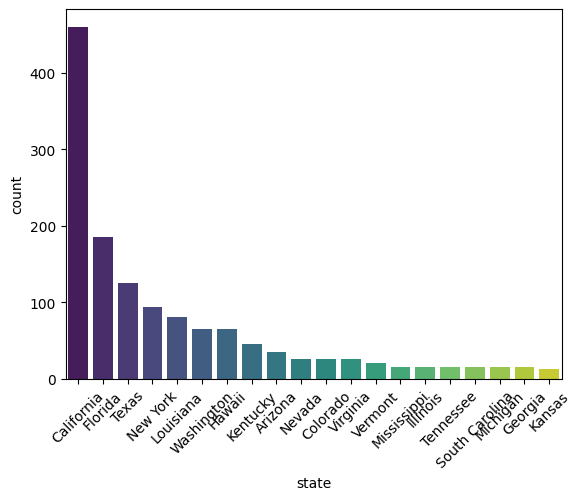

In [41]:
# Distribution of the state
category_counts = ner_df.state.value_counts().head(20)
sns.countplot(x='state', data=ner_df[ner_df['state'].isin(category_counts.index)], order=category_counts.index, palette='viridis')
plt.xticks(rotation=45)

([0, 1, 2, 3],
 [Text(0, 0, 'West'),
  Text(1, 0, 'South'),
  Text(2, 0, 'Northeast'),
  Text(3, 0, 'Midwest')])

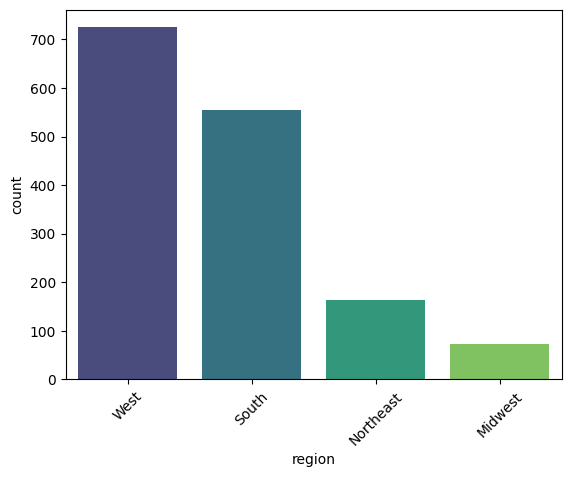

In [42]:
# Distribution of the region
category_counts = ner_df.region.value_counts().head(20)
sns.countplot(x='region', data=ner_df[ner_df['region'].isin(category_counts.index)], order=category_counts.index, palette='viridis')
plt.xticks(rotation=45)